## ARIMA Model Notebook

### Description:

This notebook will implement code for the ARIMA model for Time Series Forecasting.

As explained in the **SeriesAnalysis** notebook, this notebook will use the results already obtained in **Series Analysis**, so that the focus can be only on the Model itself.

### ARIMA Model Brief Introduction

The fundamentals of ARIMA Models are, actually, two other Time Series Models, the AR and MA.

The **AR**, Autoregressive Model, takes the past values of the series to predict the future ones. It relies on the assumption that the present values is a linear combination of lagged values.

The **MA**, Moving Average Model, relies on the assumption that the regression errors are a linear combination of the errors terms from past values.

The **ARIMA** model combines those two models and, also, is capable of *differenciate* the series to get a stationary behavior, since this is an assumption of the model as well.

In order to determine the parameters of the model, the past values that will be used to predict the present and future ones, we use the Autocorrelation and Partialcorrelation functions.

As we can see, this model is quite restrictive, even though is a classic model. We aim to see if Forecasting with Neural Networks will be a more flexible and precise approach.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import sklearn.metrics

np.random.seed(0)

### Some useful functions


In [16]:
#Read and filter data from csv files, as well as handle missing values
def read_filter(path,index,value):
    df = pd.read_csv(path)
    series = df.loc[:,[index,value]]
    series.set_index(index,inplace=True)
    series.index=pd.to_datetime(series.index)
    series = series.asfreq('d')
    series = series.interpolate()
    return series

def plot_2_series(real,model,error_value,title,xlabel="Time",ylabel="Values"):
    fig = plt.figure()

    #plotting the series
    plt.plot(real)
    plt.plot(model)

    #Title and lables
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)

    #Text displaying the RMSE
    text = "RMSE: %.4f" %error_value
    bottom = np.minimum(model.min(),real.min())
    plt.text(x=plt.xlim()[0],y=bottom,s=text)
    plt.legend(['Original Series','Predicted'])
    plt.show()
    return
    
    
# differentiate the series
def diff(series,t):
    for i in range(t):
        series = series - series.shift(1)
        series = series.dropna()
    
    return series

#train test split
def train_test(serie,numtest):
    train = serie.iloc[0:len(serie)-numtest]
    test = serie.iloc[len(serie)-numtest:]    
    return train, test
    
#Compute some error metrics
def errors(actual, predicted):
    me = np.mean(predicted.values - actual.values)  # ME
    mae = sklearn.metrics.median_absolute_error(actual,predicted)    # MAE
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(actual,predicted))  # RMSE
    
    errors = [['ME',me],['MAE',mae],['RMSE',rmse]]
    
    errors = pd.DataFrame(errors,columns=['Error','Value'])
    return errors



In [3]:
#Importing the dataset and making some changes
USD_CAD_serie = read_filter('../data/CAD=X.csv','Date','Adj Close')
USD_BRL_serie = read_filter('../data/BRL=X.csv','Date','Adj Close')
AmericanAirlines_serie = read_filter('../data/AAL2010_2019.csv','Date','Adj Close')

#differentiating the series
USD_CAD_serie_diff1 = diff(USD_CAD_serie,1)
USD_BRL_serie_diff1 = diff(USD_BRL_serie,1)
AmericanAirlines_serie_diff1 = diff(AmericanAirlines_serie,1)

## Training and Test Sets

We must divide our time series into a training and test sample. Since our series has anual seasonality, let's leave the last yeas as test sample and the rest of the series as training.

In [4]:
train_American_diff1, test_American_diff1 = train_test(AmericanAirlines_serie_diff1,12)
train_USD_CAD_diff1, test_USD_CAD_diff1 = train_test(USD_CAD_serie_diff1,12)
train_USD_BRL_diff1, test_USD_BRL_diff1 = train_test(USD_BRL_serie_diff1,12)

In [5]:
#Since our series are already stationary, the 'd' parameter in arima(p,d,q) is zero.

arima_American_diff1 = ARIMA(train_American_diff1,order=(1,0,1)).fit()
arima_USD_CAD_diff1 = ARIMA(train_USD_CAD_diff1,order=(1,0,1)).fit()
arima_USD_BRL_diff1 = ARIMA(train_USD_BRL_diff1,order=(1,0,1)).fit()

C:\Users\matno\miniconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
print('American Airlines',arima_American_diff1.summary())
print('USD/CAD',arima_USD_CAD_diff1.summary())
print('USD/BRL',arima_USD_BRL_diff1.summary())

American Airlines                                SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 3635
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2498.995
Date:                Mon, 29 Nov 2021   AIC                          -4989.990
Time:                        22:45:48   BIC                          -4965.197
Sample:                    01-02-2010   HQIC                         -4981.159
                         - 12-15-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.013      0.530      0.596      -0.018       0.032
ar.L1          0.8294      0.013     64.559      0.000       0.804       0.855
ma.L1          0.0794      0.061  

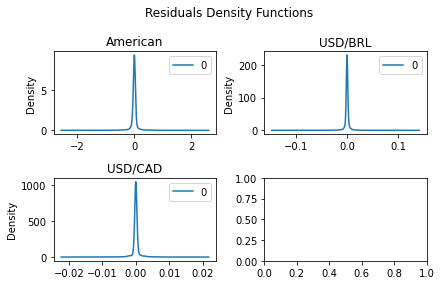

In [7]:
# Plot residual errors

resid_American = pd.DataFrame(arima_American_diff1.resid)
resid_BRL = pd.DataFrame(arima_USD_BRL_diff1.resid)
resid_CAD = pd.DataFrame(arima_USD_CAD_diff1.resid)


fig, ax = plt.subplots(2,2)
fig.suptitle('Residuals Density Functions')
ax[0,0].set_title('American')
ax[0,1].set_title('USD/BRL')
ax[1,0].set_title('USD/CAD')

fig.tight_layout()

resid_American.plot(kind='kde', ax=ax[0,0])
resid_BRL.plot(kind='kde', ax=ax[0,1])
resid_CAD.plot(kind='kde', ax=ax[1,0])
plt.show()


Our residuals density are fairly normal with mean zero and variance constant

### Prediction

Once your model is fitted, we can predict the value of the series with the model and compare the results.

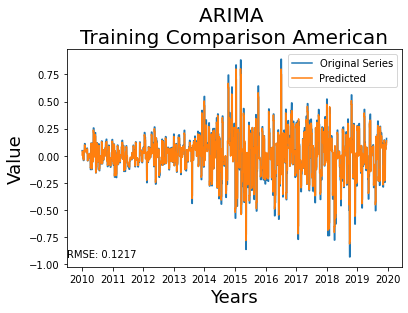

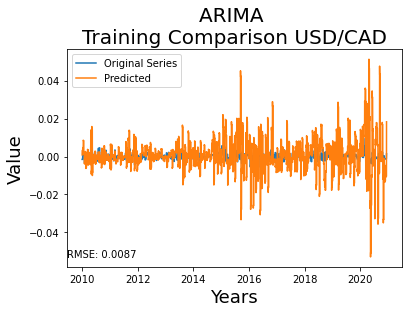

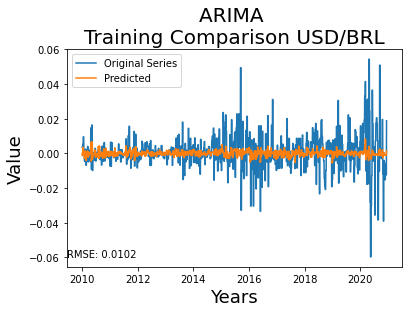


American Model Prediction Errors
  Error     Value
0    ME  0.000007
1   MAE  0.021084
2  RMSE  0.121652

USD/CAD Model Prediction Errors
  Error     Value
0    ME  0.000781
1   MAE  0.003615
2  RMSE  0.008736

USD/BRL Model Prediction Errors
  Error     Value
0    ME -0.000785
1   MAE  0.004314
2  RMSE  0.010235


In [17]:
arima_pred_American_diff1 = arima_American_diff1.predict()
arima_pred_USD_BRL_diff1 = arima_USD_BRL_diff1.predict()
arima_pred_USD_CAD_diff1 = arima_USD_CAD_diff1.predict()


plot_2_series(real=train_American_diff1,
            model=arima_pred_American_diff1,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(train_American_diff1,arima_pred_American_diff1)),
            title='ARIMA \nTraining Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=train_USD_CAD_diff1,
            model=arima_pred_USD_BRL_diff1,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(train_USD_CAD_diff1,arima_pred_USD_BRL_diff1)),
            title='ARIMA \nTraining Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=train_USD_BRL_diff1,
            model=arima_pred_USD_CAD_diff1,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(train_USD_BRL_diff1,arima_pred_USD_CAD_diff1)),
            title='ARIMA \nTraining Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican Model Prediction Errors")
print(errors(train_American_diff1,arima_pred_American_diff1))
print("\nUSD/CAD Model Prediction Errors")
print(errors(train_USD_CAD_diff1,arima_pred_USD_BRL_diff1))
print("\nUSD/BRL Model Prediction Errors")
print(errors(train_USD_BRL_diff1,arima_pred_USD_CAD_diff1))


### Model conclusion

By looking at the plot above, we see that the **ARIMA** Model does seem to predict the series pretty well.

# COMPLETE

### Forecasting

C:\Users\matno\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


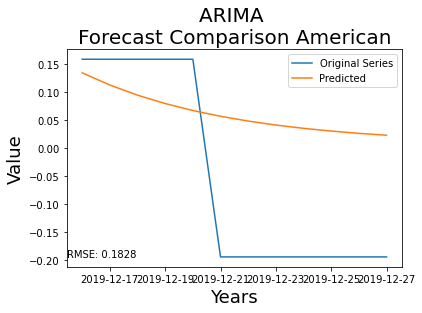

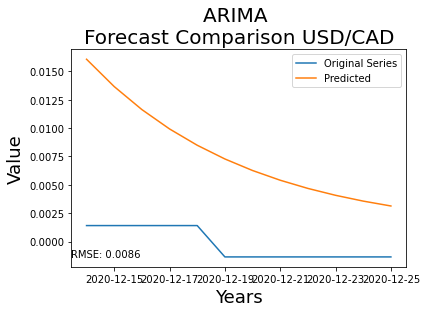

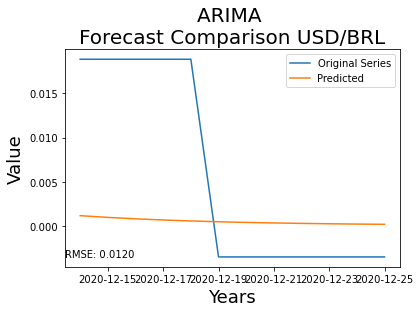


American Model Forecast Errors
  Error     Value
0    ME  0.110143
1   MAE  0.219871
2  RMSE  0.182837

USD/CAD Model Forecast Errors
  Error     Value
0    ME  0.008049
1   MAE  0.007345
2  RMSE  0.008564

USD/BRL Model Forecast Errors
  Error     Value
0    ME -0.005288
1   MAE  0.003941
2  RMSE  0.011995


In [18]:
arima_for_American = arima_American_diff1.predict(start=test_American_diff1.index.astype(str)[0],end=test_American_diff1.index.astype(str)[-1])
arima_for_BRL = arima_USD_BRL_diff1.predict(start=test_USD_BRL_diff1.index.astype(str)[0],end=test_USD_BRL_diff1.index.astype(str)[-1])
arima_for_CAD = arima_USD_CAD_diff1.predict(start=test_USD_CAD_diff1.index.astype(str)[0],end=test_USD_CAD_diff1.index.astype(str)[-1])

plot_2_series(real=test_American_diff1,
            model=arima_for_American,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(test_American_diff1,arima_for_American)),
            title='ARIMA \nForecast Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=test_USD_CAD_diff1,
            model=arima_for_BRL,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(test_USD_CAD_diff1,arima_for_BRL)),
            title='ARIMA \nForecast Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=test_USD_BRL_diff1,
            model=arima_for_CAD,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(test_USD_BRL_diff1,arima_for_CAD)),
            title='ARIMA \nForecast Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican Model Forecast Errors")
print(errors(test_American_diff1,arima_for_American))
print("\nUSD/CAD Model Forecast Errors")
print(errors(test_USD_CAD_diff1,arima_for_BRL))
print("\nUSD/BRL Model Forecast Errors")
print(errors(test_USD_BRL_diff1,arima_for_CAD))

We can see that the forecast is quite horrible, actually. If we look at the forecast values, we can see that after a few steps it stays always in the same value, the mean

## Conclusion:

The **ARIMA Model** for Sotck Returns and Currency Time Series Analysis and Forecast seems a bad model, since it is not capable of modeling the series exact behavior, neither forecast for large horizons.